### SageMaker Stable diffusion Quick Kit - Inference 部署(ControlNet)
   [SageMaker Stable Diffusion Quick Kit](https://github.com/aws-samples/sagemaker-stablediffusion-quick-kit) 提供了一组开箱即用的代码、配置文件，它可以帮助客户在亚马逊云上使用Amazon SageMaker , Lambda, Cloudfront快速构建Stable diffusion AI绘图服务.
   
   ![架构](https://raw.githubusercontent.com/aws-samples/sagemaker-stablediffusion-quick-kit/main/images/architecture.png)


#### 前提条件
1. 亚马逊云账号
2. 建议使用ml.g4dn.xlarge/ml.g5.xlarge

### Notebook部署步骤
1. 升级boto3, sagemaker python sdk
2. 编译docker image
3. 部署AIGC推理服务
    * 配置模型参数
    * 配置异步推理
    * 部署SageMaker Endpoint 
4. 测试ControlNet模型
5. 清除资源


### 0. 升级boto3, sagemaker python sdk

In [ ]:
!pip install --upgrade boto3 sagemaker

In [1]:
#导入对应的库

import re
import os
import json
import uuid

import numpy as np
import pandas as pd
from time import gmtime, strftime


import boto3
import sagemaker

from sagemaker import get_execution_role,session

role = get_execution_role()


sage_session = session.Session()
bucket = sage_session.default_bucket()
aws_region = boto3.Session().region_name


print(f'sagemaker sdk version: {sagemaker.__version__}\nrole:  {role}  \nbucket:  {bucket}')

sagemaker sdk version: 2.146.0
role:  arn:aws:iam::022346938362:role/sd-webui-sm-notebook-ExecutionRole-1K975UHZ65FOK  
bucket:  sagemaker-us-east-1-022346938362


### 1. 准备模型文件

从Civitai网站下载safetensors文件，并将格式转换为 Diffusers 支持的格式。

In [ ]:
# 更改 work dir
%cd ~/SageMaker/sagemaker-stablediffusion-quick-kit/inference/sagemaker/byoc

# 安装依赖包
! pip install -e ./diffusers
! pip install transformers omegaconf safetensors

# # 下载模型文件
# ! wget https://civitai.com/api/download/models/16859 -O blueberrymix.safetensors

# # 下载模型转换脚本
# ! git clone https://github.com/huggingface/diffusers

In [ ]:
# 执行模型转换脚本
!python diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py \
  --checkpoint_path ./blueberrymix.safetensors \
  --dump_path ./model_output \
  --from_safetensors

In [ ]:
# import torch
# 执行模型转换脚本
!python diffusers/scripts/convert_original_stable_diffusion_to_diffusers.py \
  --checkpoint_path ../byos/anything-v5.safetensors \
  --dump_path ../byos/binc-diffuser-model-anythingv5 \
  --from_safetensors

查看输出文件，格式类似：
```
total 32
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:34 feature_extractor
-rw-rw-r-- 1 ec2-user ec2-user  579 Apr 20 03:33 model_index.json
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 safety_checker
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 scheduler
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 text_encoder
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 tokenizer
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 unet
drwxrwxr-x 2 ec2-user ec2-user 4096 Apr 20 03:33 vae
```

In [ ]:
!ls -l ./model_output

In [ ]:
# 上传模型文件到S3
real_model_s3_path = 's3://{0}/{1}/assets/blueberry/uncompressed/'.format(bucket, 'stablediffusion')
!aws s3 sync ./model_output $real_model_s3_path

In [ ]:
## 查看S3文件
!aws s3 ls --recursive $real_model_s3_path

### 下载LoRA模型文件



In [2]:
# https://civitai.com/models/14171/cutegirlmix4  , mix4
!wget https://civitai.com/api/download/models/16677 -O cute_girl_mix_lora.safetensors

# https://civitai.com/models/39174/star-wars-sith-outfit , trigger words: STHOUTFIT
!wget https://civitai.com/api/download/models/45884 -O starwar_lora.safetensors

!wget https://civitai.com/api/download/models/32988 -O blindbox_lora.safetensors

lora_model_s3_path_1 = f's3://{bucket}/stablediffusion/assets/lora/cute_girl_mix_lora.safetensors'
lora_model_s3_path_2 = f's3://{bucket}/stablediffusion/assets/lora/starwar_lora.safetensors'
lora_model_s3_path_3 = f's3://{bucket}/stablediffusion/assets/lora/blindbox_lora.safetensors'

# 上传LoRA模型文件到S3
!aws s3 cp cute_girl_mix_lora.safetensors $lora_model_s3_path_1
!aws s3 cp starwar_lora.safetensors $lora_model_s3_path_2
!aws s3 cp blindbox_lora.safetensors $lora_model_s3_path_3

### 2. 编译docker image

需要给当前的执行环境(Notebook Instance / Studio) 绑定的 IAM role 附加访问 ECR 镜像仓库的权限。

测试环境下，可以直接赋予 'AmazonEC2ContainerRegistryFullAccess' 策略。

In [ ]:
!./build_push.sh

### 3. 部署AIGC推理服务

#### 3.1 创建dummy model_data 文件(真正的模型使用code/infernece.py进行加载)

In [ ]:
!touch dummy
!tar czvf model.tar.gz dummy sagemaker-logo-small.png
assets_dir = 's3://{0}/{1}/assets/'.format(bucket, 'stablediffusion')
model_data = 's3://{0}/{1}/assets/model.tar.gz'.format(bucket, 'stablediffusion')
!aws s3 cp model.tar.gz $assets_dir
!rm -f dummy model.tar.gz

#### 3.2 创建 model 配置

In [3]:

boto3_session = boto3.session.Session()
current_region=boto3_session.region_name

client = boto3.client("sts")
account_id=client.get_caller_identity()["Account"]

client = boto3.client('sagemaker')

#使用步骤2编译好的docker images
container = f'{account_id}.dkr.ecr.{current_region}.amazonaws.com/sd-inference-v2'

model_data = f's3://{bucket}/stablediffusion/assets/model.tar.gz'


model_name = 'AIGC-Quick-Kit-' +  strftime("%Y-%m-%d-%H-%M-%S", gmtime())
role = get_execution_role()


# model_name: 支持多种格式
#  - 'runwayml/stable-diffusion-v1-5' 从 hf 下载预训练模型
#  - 's3://bkt/folder/blueberrymix_model.tar.gz' 从s3下载模型压缩文件
#  - 's3://bkt/folder/' 从 s3 文件夹下载未压缩模型文件
primary_container = {
    'Image': container,
    'ModelDataUrl': model_data, # fake model file
    'Environment':{
        's3_bucket': bucket,
        'control_net_enable': 'false',
        'watermarket': 'false',
        # 'model_name': real_model_s3_path, # 真正的 SD 模型文件,
        'model_name': 'sakistriker/Anything_V5_PrtRE', # 真正的 SD 模型文件,
        'lora_models': json.dumps({
            'cutegirl': lora_model_s3_path_1,  # model_name: uri
            'starwar': lora_model_s3_path_2,
            'blindbox_lora': lora_model_s3_path_3,
        })
    }
}

create_model_response = client.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container,
)

create_model_response

{'ModelArn': 'arn:aws:sagemaker:us-east-1:022346938362:model/aigc-quick-kit-2023-05-08-09-20-25',
 'ResponseMetadata': {'RequestId': 'b62ff4f7-b371-4cf2-9add-8415384ea5fd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amzn-requestid': 'b62ff4f7-b371-4cf2-9add-8415384ea5fd',
   'content-type': 'application/x-amz-json-1.1',
   'content-length': '96',
   'date': 'Mon, 08 May 2023 09:20:26 GMT'},
  'RetryAttempts': 0}}

In [23]:
_time_tag = strftime("%Y-%m-%d-%H-%M-%S", gmtime())
_variant_name =  'AIGC-Quick-Kit-'+ _time_tag
endpoint_config_name = 'AIGC-Quick-Kit-' +  _time_tag

response = client.create_endpoint_config(
    EndpointConfigName=endpoint_config_name,
    ProductionVariants=[
        {
            'VariantName': _variant_name,
            'ModelName': model_name,
            'InitialInstanceCount': 1,
            'InstanceType': 'ml.g4dn.2xlarge',
            'InitialVariantWeight': 1
        },
    ]
    ,
    AsyncInferenceConfig={
        'OutputConfig': {
            'S3OutputPath': f's3://{bucket}/stablediffusion/asyncinvoke/out/',
            "NotificationConfig": {
                "SuccessTopic": "arn:aws:sns:us-east-1:022346938362:test-sagemaker-aysnc",
                "ErrorTopic": "arn:aws:sns:us-east-1:022346938362:test-sagemaker-aysnc",
            }
        },
    }
)

#### 3.3 部署SageMaker endpoint

In [24]:
endpoint_name = f'AIGC-Quick-Kit-{str(uuid.uuid4())}'


response = client.create_endpoint(
    EndpointName=endpoint_name,
    EndpointConfigName=endpoint_config_name,
)



print(f'终端节点:{endpoint_name} 正在创建中，首次启动中会加载模型，请耐心等待, 请在控制台上查看状态')


终端节点:AIGC-Quick-Kit-8f2fd2b6-39e1-44a0-8668-627a3e49d833 正在创建中，首次启动中会加载模型，请耐心等待, 请在控制台上查看状态


### 4. 测试

### 4.1 辅助方法 

In [6]:
import time
import uuid
import io
import traceback
from PIL import Image


s3_resource = boto3.resource('s3')

def get_bucket_and_key(s3uri):
    pos = s3uri.find('/', 5)
    bucket = s3uri[5 : pos]
    key = s3uri[pos + 1 : ]
    return bucket, key


def predict_async(endpoint_name,payload):
    print('Start time: ', time.strftime("%H:%M:%S"))
    runtime_client = boto3.client('runtime.sagemaker')
    input_file=str(uuid.uuid4())+".json"
    s3_resource = boto3.resource('s3')
    s3_object = s3_resource.Object(bucket, f'stablediffusion/asyncinvoke/input/{input_file}')
    payload_data = json.dumps(payload).encode('utf-8')
    s3_object.put( Body=bytes(payload_data))
    input_location=f's3://{bucket}/stablediffusion/asyncinvoke/input/{input_file}'
    print(f'input_location: {input_location}')
    response = runtime_client.invoke_endpoint_async(
        EndpointName=endpoint_name,
        InputLocation=input_location
    )
    result =response.get("OutputLocation",'')
    print('result', result)
    wait_async_result(result)
    print('End time: ', time.strftime("%H:%M:%S"))


def s3_object_exists(s3_path):
    """
    s3_object_exists
    """
    try:
        s3 = boto3.client('s3')
        base_name=os.path.basename(s3_path)
        _,ext_name=os.path.splitext(base_name)
        bucket,key=get_bucket_and_key(s3_path)
        
        s3.head_object(Bucket=bucket, Key=key)
        return True
    except Exception as ex:
        # print("job is not completed, waiting...")   
        return False
    
def draw_image(output_location):
    try:
        bucket, key = get_bucket_and_key(output_location)
        obj = s3_resource.Object(bucket, key)
        body = obj.get()['Body'].read().decode('utf-8') 
        predictions = json.loads(body)
        print(predictions['result'])
        for image in predictions['result']:
            bucket, key = get_bucket_and_key(image)
            obj = s3_resource.Object(bucket, key)
            bytes = obj.get()['Body'].read()
            image = Image.open(io.BytesIO(bytes))
            #resize image to 50% size
            half = 0.5
            out_image = image.resize( [int(half * s) for s in image.size] )
            out_image.show()
    except Exception as e:
        pass
        # print("result is not completed, waiting...")   
    

    
def wait_async_result(output_location,timeout=60):
    current_time=0
    while current_time<timeout:
        if s3_object_exists(output_location):
            print("have async result")
            draw_image(output_location)
            break
        else:
            time.sleep(5)

            
def check_sendpoint_status(endpoint_name):
    client = boto3.client('sagemaker')
    response = client.describe_endpoint(
        EndpointName=endpoint_name
    )
    if response['EndpointStatus'] !='InService':
        raise Exception (f'{endpoint_name} not ready , please wait....')
    else:
        status = response['EndpointStatus']
        print(f'{endpoint_name} is ready, status: {status}')

#### 检查endpoint 状态

In [19]:
check_sendpoint_status(endpoint_name)

AIGC-Quick-Kit-d29afb75-65e5-4e86-97b4-d5287302601a is ready, status: InService


### 4.1 图生图测试

In [ ]:
with open('图片base63编码.txt', 'r') as f:
    b_64 = f.read()

payload={
    "prompt": "best quality, 1girl",
    "negative_prompt":"",
    "steps": 40,
    "sampler":"dpm2_a",
    "seed":2589384173, # use -1 for random
    "height": 512, 
    "width": 512,
    "count":2,
    "guidance_scale": 7,
    "task_type": "img2img", # or txt2img
    # "init_image": "https://i.pinimg.com/originals/bd/61/7c/bd617c144e974211720214ab9ccaf5a8.jpg" # or base64 str    
    "init_image": b_64,
}

predict_async(endpoint_name,payload)


### 4.2 LoRA 测试 

Start time:  09:43:26
input_location: s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/input/01e48e76-480b-4a58-b614-5ac3a54f4a7e.json
result s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/out/079e0bcf-0f7a-4d53-bd04-486ec37db701.out
have async result
['s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/images/deaa6843-08cc-47d6-b1cb-41d8ebc4b5d1.jpg']


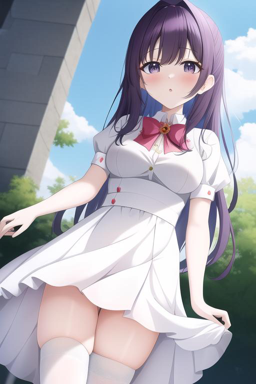

End time:  09:43:52


In [8]:
payload={
    "prompt": "hinatsuru ai, (((main dress style))), 8k, masterpiece, absurdres, anime, screencap,",
    "negative_prompt":"leather, lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry, blurry, bad hands, missing fingers, error, cropped, normal quality, fewer digit, owres, extra digit, worst quality, jpeg artifacts, lowres, bad feet, disfigured, missing arms, long neck, ugly, bad proportions, multiple breasts, fused fingers, extra legs, poorly drawn hands, cloned face, malformed hands, mutated hands and fingers, missing limb, malformed mutated, unclear eyes, fused hand, disappearing thigh, disappearing calf, bad asshole, bad pussy, bad body, on hand with less than 5 fingers, crown , stacked torses, stacked hands, totem pole",
    "steps": 25,
    "sampler":"euler_a",
    "seed": 2073839452, # use -1 for random
    "height": 768,
    "width": 512,
    "count": 1,
    "guidance_scale": 7,
    "task_type": "txt2img", # or img2img
}

predict_async(endpoint_name,payload)

Start time:  09:45:23
input_location: s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/input/5fd379ab-ed1c-4d67-b9e2-36dd66379ec5.json
result s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/out/40762638-6249-4ed6-b8aa-4429460024a5.out
have async result
['s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/images/215f6e78-a531-41d7-a6b6-691ff4752e21.jpg']


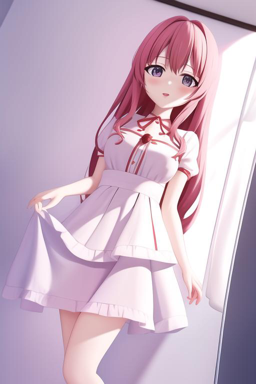

End time:  09:45:38


In [11]:
payload["lora"] = {
    "blindbox_lora": 1.3,
    "starwar": 0.1
}

predict_async(endpoint_name,payload)

Start time:  09:45:38
input_location: s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/input/7450a0a9-6e0c-4437-bc8e-d0e5c4dde4dd.json
result s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/out/ca1a59b3-0d83-4ba3-b654-b1d367267a1f.out
have async result
['s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/images/e9b22a70-7bc2-4ea2-a612-570693e62974.jpg']


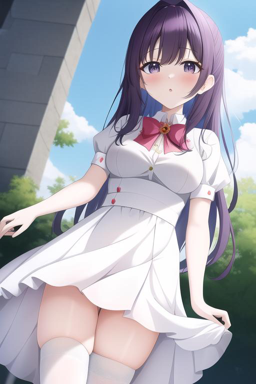

End time:  09:45:54


In [12]:
payload["lora"] = {}

predict_async(endpoint_name,payload)

### 4.3 Denoising 强度测试 

Start time:  09:47:55
input_location: s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/input/ac37023c-8341-44bf-b537-8d30d9b7ef15.json
result s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/out/d2e44e23-41c9-4b10-b381-baf1315e170c.out
have async result
['s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/images/91322453-200a-4568-afbf-b11999e24c8f.jpg']


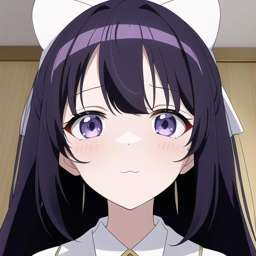

End time:  09:48:11


In [13]:
payload["task_type"] = 'img2img'
payload["init_image"] = "https://i.pinimg.com/originals/bd/61/7c/bd617c144e974211720214ab9ccaf5a8.jpg" # or base64 str    
payload["strength"] = 0.9

predict_async(endpoint_name,payload)

Start time:  09:50:32
input_location: s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/input/56ae7d0d-37b4-42f9-8a64-e51b1a84a5da.json
result s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/out/05f364b0-4dfe-4f76-9a76-1a065e383958.out
have async result
['s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/images/0b11285d-44bd-4786-a813-ed52757f33e7.jpg']


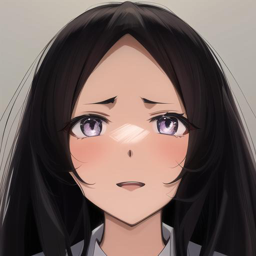

End time:  09:50:38


In [14]:
payload["strength"] = 0.6
predict_async(endpoint_name,payload)

### 4.3 Sampler 测试

Sampler 参数的映射关系：

    "euler_a": Euler a
    "eular": Euler
    "heun": Heun
    "lms": LMS
    "lms_k": LMS
    "dpm2": DPM2
    "dpm2_a": DPM2 a
    "dpmpp_2s_a": DPM++ 2S a
    "dpmpp_2m": DPM++ 2M
    "dpmpp_2m_k": DPM++ 2M  Karras
    "dpmpp_sde": DPM++ SDE
    "dpmpp_sde_k": DPM++ SDE Karras
    "ddim": DDIM
    "plms": PLMS,  # plms = pndm config.skip_prk_steps, ref: https://github.com/huggingface/diffusers/issues/960

Start time:  03:10:02
input_location: s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/input/893b88b5-27b6-44d8-acf5-9e282f6839dc.json
result s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/out/673c4e5c-fa0a-4eb1-b5fc-2bba6bbdcbbb.out
have async result
['s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/images/f53da1eb-ba42-4e9b-9db6-a36b23dbf23e.jpg']


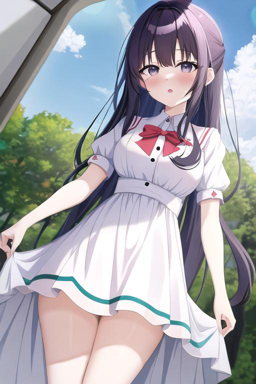

End time:  03:10:23
Start time:  03:10:23
input_location: s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/input/e1cd793c-6c4f-4b65-b36b-632eb495de14.json
result s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/out/779f83bb-d3bd-47fc-9193-1bb929cfb2a4.out
have async result
['s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/images/c839a576-cd36-4557-b7c8-3d1bf975788c.jpg']


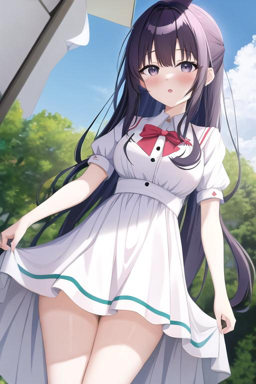

End time:  03:10:34
Start time:  03:10:34
input_location: s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/input/ae657ddd-2ba6-4ddc-ac62-2dcd051a0770.json
result s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/out/a85b6ac1-e39d-4c74-a3ed-972b19768184.out
have async result
['s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/images/d3410434-6461-467c-9ee8-0294f2c34d62.jpg']


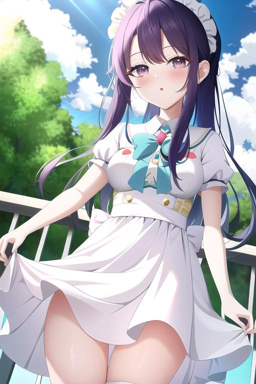

End time:  03:10:49
Start time:  03:10:49
input_location: s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/input/82195bc6-f886-4464-9652-5bb50f219e01.json
result s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/out/9964d025-92a1-4b12-8994-b8d7dfc196e9.out
have async result
['s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/images/4a9d4aa1-e05d-4a3f-9201-4b23264cb71f.jpg']


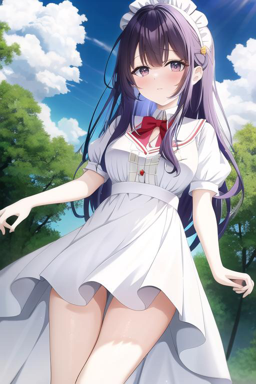

End time:  03:11:05


In [20]:
payload={
    "prompt": "hinatsuru ai, (((main dress style))), 8k, masterpiece, absurdres, anime, screencap,",
    "negative_prompt":"leather, lowres, bad anatomy, bad hands, text, error, missing fingers, extra digit, fewer digits, cropped, worst quality, low quality, normal quality, jpeg artifacts, signature, watermark, username, blurry, blurry, bad hands, missing fingers, error, cropped, normal quality, fewer digit, owres, extra digit, worst quality, jpeg artifacts, lowres, bad feet, disfigured, missing arms, long neck, ugly, bad proportions, multiple breasts, fused fingers, extra legs, poorly drawn hands, cloned face, malformed hands, mutated hands and fingers, missing limb, malformed mutated, unclear eyes, fused hand, disappearing thigh, disappearing calf, bad asshole, bad pussy, bad body, on hand with less than 5 fingers, crown , stacked torses, stacked hands, totem pole",
    "steps": 25,
    "sampler":"",
    "seed": 2073839452, # use -1 for random
    "height": 768,
    "width": 512,
    "count": 1,
    "guidance_scale": 7,
    "task_type": "txt2img", # or img2img
}

for sampler in ['dpmpp_2m', 'dpmpp_2m_k', 'dpmpp_sde', 'dpmpp_sde_k']:
    payload['sampler'] = sampler
    predict_async(endpoint_name,payload)

### 4.4 错误处理

异步调用的错误处理可以通过 SNS Topic 实现(如之前步骤中的 NotificationConfig 设置)。SNS的消费端可以是 Lambda、EMail、http endpoint 等多种类型。推理成功和失败的时间都会即时推送到对应的消费端。

参考的错误数据格式：

```json
{"awsRegion":"us-east-1","eventTime":"2023-05-12T04:09:43.422Z","receivedTime":"2023-05-12T04:09:43.365Z","invocationStatus":"Failed","failureReason":"ClientError: Received server error (500) from model. See the SageMaker Endpoint logs in your account for more information.","requestParameters":{"endpointName":"AIGC-Quick-Kit-8f2fd2b6-39e1-44a0-8668-627a3e49d833","inputLocation":"s3://sagemaker-us-east-1-xxxx/stablediffusion/asyncinvoke/input/b9fc9443-1474-4fb0-ad55-xxxxx.json"},"responseParameters":{},"inferenceId":"8d201f31-eb05-45e2-871f-e0f716f40a6b","eventVersion":"1.0","eventSource":"aws:sagemaker","eventName":"InferenceResult"}
```

In [27]:
with open('图片base63编码.txt', 'r') as f:
    b_64 = f.read()

payload={
    "prompt": "best quality, 1girl",
    "negative_prompt":"",
    "steps": 20,
    "sampler":"dpm2_a",
    "seed":2589384173, # use -1 for random
    "height": 512, 
    "width": 512,
    "count":1,
    "guidance_scale": 7,
    "task_type": "img2img", # or txt2img
    # "init_image": "https://i.pinimg.com/originals/bd/61/7c/bd617c144e974211720214ab9ccaf5a8.jpg" # or base64 str    
    "init_image": "abcdxxxx" + b_64,
}

predict_async(endpoint_name,payload)


Start time:  04:10:43
input_location: s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/input/916c9c5a-b702-4bd6-aef1-cb90bc603fa9.json
result s3://sagemaker-us-east-1-022346938362/stablediffusion/asyncinvoke/out/7591e74e-c171-4159-90e0-4505da53ba42.out


KeyboardInterrupt: 

### 5 清除资源

In [ ]:
response = client.delete_endpoint(
    EndpointName=endpoint_name
    
)

response = client.delete_endpoint_config(
    EndpointConfigName=endpoint_config_name
)


print(f'终端节点:{endpoint_name} 已经被清除，请在控制台上查看状态')
